A brute force way (gridsearch) to automatically find the best combo of parameters for the KNN models that best fits our data with respect to cross-validated accuracy

An introduction to Grid Search  
https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998

## EDA

In [1]:
# allow several outputs from one cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'
# lazy import common packages
# from pyforest import *
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# load in our dataset using pandas
pima = pd.read_csv('data/pima.csv')

pima.head()


,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [3]:
pima_column_names = ['times_pregnant', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness', 'serum_insulin', 'bmi', 'pedigree_function', 'age', 'onset_diabetes']

pima = pd.read_csv('data/pima.csv', names=pima_column_names)

pima.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
pima['onset_diabetes'].value_counts() 
pima['onset_diabetes'].value_counts(normalize=True) 
# get null accuracy, 65% did not develop diabetes

0    0.651042
1    0.348958
Name: onset_diabetes, dtype: float64

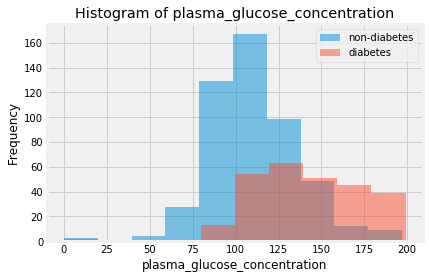

In [5]:
# get a histogram of the plasma_glucose_concentration column for
# both classes

col = 'plasma_glucose_concentration'
plt.hist(pima[pima['onset_diabetes']==0][col], 10, alpha=0.5, label='non-diabetes')
plt.hist(pima[pima['onset_diabetes']==1][col], 10, alpha=0.5, label='diabetes')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

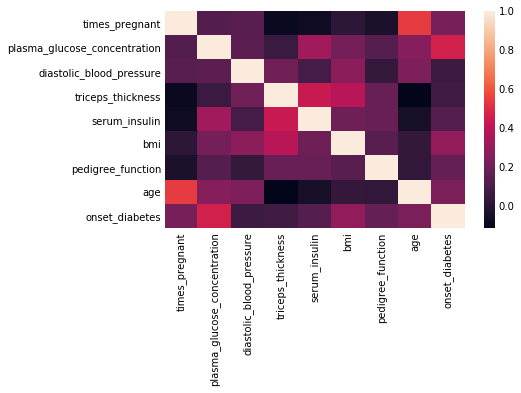

In [6]:
sns.heatmap(pima.corr())

In [7]:
pima.corr()['onset_diabetes'] # numerical correlation matrix

times_pregnant                  0.221898
plasma_glucose_concentration    0.466581
diastolic_blood_pressure        0.065068
triceps_thickness               0.074752
serum_insulin                   0.130548
bmi                             0.292695
pedigree_function               0.173844
age                             0.238356
onset_diabetes                  1.000000
Name: onset_diabetes, dtype: float64

In [8]:
pima.count()

times_pregnant                  768
plasma_glucose_concentration    768
diastolic_blood_pressure        768
triceps_thickness               768
serum_insulin                   768
bmi                             768
pedigree_function               768
age                             768
onset_diabetes                  768
dtype: int64

In [9]:
pima.shape

(768, 9)

In [10]:
pima['onset_diabetes'].value_counts(normalize=True) 

0    0.651042
1    0.348958
Name: onset_diabetes, dtype: float64

In [11]:
pima.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
# Our number of missing values is (incorrectly) 0
pima['serum_insulin'].isnull().sum()


pima['serum_insulin'] = pima['serum_insulin'].map(lambda x:x if x != 0 else None)
# manually replace all 0's with a None value

pima['serum_insulin'].isnull().sum()
# check the number of missing values again


374

In [13]:
columns = ['serum_insulin', 'bmi', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness']
for col in columns:
    pima[col].replace([0], [None], inplace=True)

In [14]:
pima.isnull().sum()  # this makes more sense now!

times_pregnant                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   374
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

In [15]:
# drop the rows with missing values
pima_dropped = pima.dropna()

num_rows_lost = round(100*(pima.shape[0] - pima_dropped.shape[0])/float(pima.shape[0]))

print("retained {}% of rows".format(num_rows_lost))
# lost over half of the rows!

retained 49% of rows


Text(0, 0.5, '% change')

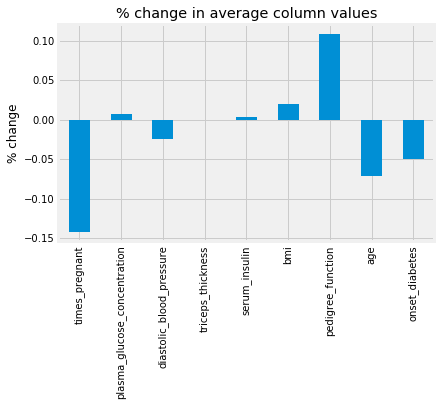

In [16]:
ax = ((pima_dropped.mean() - pima.mean()) / pima.mean()).plot(kind='bar', title='% change in average column values')
ax.set_ylabel('% change')

## Some machine learning

In [17]:
# now lets do some machine learning

# note we are using the dataset with the dropped rows

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X_dropped = pima_dropped.drop('onset_diabetes', axis=1)
# create our feature matrix by removing the response variable
print("learning from {} rows".format(X_dropped.shape[0]))
y_dropped = pima_dropped['onset_diabetes']


# our grid search variables and instances

# KNN parameters to try
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}

knn = KNeighborsClassifier()  # instantiate a KNN model

grid = GridSearchCV(knn, knn_params)
grid.fit(X_dropped, y_dropped)

print(grid.best_score_, grid.best_params_)
# but we are learning from way fewer rows..


learning from 392 rows
0.7348263550795197 {'n_neighbors': 7}


In [18]:
active_imports()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


['import pandas as pd',
 'import matplotlib.pyplot as plt',
 'import seaborn as sns']